import libraries

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as du
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

read MNIST data

In [3]:
train_data = datasets.MNIST('.', train=True, download=True,
                            transform=transforms.Compose([
                                transforms.ToTensor()
                            ]))
test_data = datasets.MNIST('.', train=False,
                           transform=transforms.Compose([
                               transforms.ToTensor()
                           ]))
print("train images", train_data.data.size())
print("train labels", train_data.targets.size())
print("test images", test_data.data.size())
print("test labels", test_data.targets.size())

9913344it [00:00, 62198880.46it/s]                             


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



29696it [00:00, 106821656.59it/s]        


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



1649664it [00:00, 38087856.23it/s]         

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw


5120it [00:00, 17674762.53it/s]         


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw

train images torch.Size([60000, 28, 28])
train labels torch.Size([60000])
test images torch.Size([10000, 28, 28])
test labels torch.Size([10000])


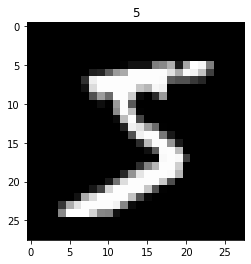

In [4]:
plt.imshow(train_data.data[0].numpy(), cmap='gray')
plt.title('%i' % train_data.targets[0])
plt.show()

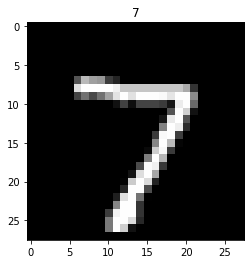

In [5]:
plt.imshow(test_data.data[0].numpy(), cmap='gray')
plt.title('%i' % test_data.targets[0])
plt.show()

define MLP model

In [6]:
class MLP(nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim):
        '''in_dim: input layer dim
           hidden_dim: hidden layer dim
           out_dim: output layer dim'''
        
        super(MLP, self).__init__()
        
        # images are 28x28 so flatten them into 784d vec
        self.flatten = nn.Flatten()
        
        #two fully connected layers
        self.fc1 = nn.Linear(in_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, out_dim)

    def forward(self, x):
        # since x is 28x28, flatten it first
        x = self.flatten(x)
        
        # compute output of fc1, and apply relu activation
        x = F.relu(self.fc1(x))
        
        # compute output layer
        # no activation: cross entropy will compute softmax
        x = self.fc2(x)
        return x

Set up training

In [7]:
device = f'cuda:0' if torch.cuda.is_available() else 'cpu'
print(f"using device: {device}")
batch_size = 1000
learning_rate = 0.01
epochs = 5

# set model and optimizer
# images are 28x28 as inputs
# use 384d hidden layer
# output is 10d since there are 10 classes
model = MLP(28*28, 384, 10)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# load training data in batches
train_loader = du.DataLoader(dataset=train_data,
                             batch_size=batch_size,
                             shuffle=True)
# send model over to device
model = model.to(device)
model.train()

using device: cuda:0


MLP(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=784, out_features=384, bias=True)
  (fc2): Linear(in_features=384, out_features=10, bias=True)
)

Training loop over batches

In [10]:
for epoch in range(1, epochs + 1):    
    sum_loss = 0.
    for batch_idx, (data, target) in enumerate(train_loader):
        # send batch over to device
        data, target = data.to(device), target.to(device)
        
        # zero out prev gradients
        optimizer.zero_grad()
        
        # run the forward pass
        output = model(data)
        
        # compute loss/error
        loss = F.cross_entropy(output, target)
        
        # sum up batch losses
        sum_loss += loss.item()
        
        # compute gradients and take a step
        loss.backward()
        optimizer.step()
        
    # average loss per example    
    sum_loss /= len(train_loader.dataset)
    print(f'Epoch: {epoch}, Loss: {sum_loss:.6f}')

Epoch: 1, Loss: 0.000026
Epoch: 2, Loss: 0.000024
Epoch: 3, Loss: 0.000017
Epoch: 4, Loss: 0.000010
Epoch: 5, Loss: 0.000009


Now do testing

In [11]:
# load test images in batches
test_loader = du.DataLoader(dataset=test_data,
                            batch_size=batch_size,
                            shuffle=True)

# set model in eval mode, since we are no longer training
model.eval()
test_loss = 0
correct = 0

# turn of gradient computation, will speed up testing
with torch.no_grad():
    for batch_idx, (data, target) in enumerate(test_loader):
        # send batches to device
        data, target = data.to(device), target.to(device)
        
        # compute forward pass and loss
        output = model(data)
        loss = F.cross_entropy(output, target)
        
        # sum up batch loss
        test_loss += loss.item()

        # get the index/class of the max log-probability
        output = F.log_softmax(output, dim=1)
        pred = output.max(dim=1)[1]

        # add up number of correct predictions
        correct += torch.sum(pred == target)
  
    # test loss per example
    test_loss /= len(test_loader.dataset)
    
    # final test accuracy
    test_acc = correct / len(test_loader.dataset)
    print(f'Test loss: {test_loss:.6f}, accuracy: {test_acc:.4f}',
          f'correct: {correct}')

Test loss: 0.000078, accuracy: 0.9795 correct: 9795
